# Wine quality analysis

Clustering the vinho verde dataset to try and identify varieties.  

In [282]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from wine_quality.radarchart import radar_factory
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Tuple, List

In [99]:
white = pd.read_csv('data/winequality-white.csv',sep =';')
red = pd.read_csv('data/winequality-red.csv', sep =';')
wine = pd.concat([
    white,
    red,
    ]
)

In [109]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [110]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Cluster together or separately?

In [316]:
labels = ['white','red','both']
all_bics = []
for data, name in zip([white, red, wine],labels):
    bics = []
    for n in np.arange(1,9):
        gm = GaussianMixture(n_components=n)
        gm.fit(data)
        bics.append(gm.bic(data))
    all_bics.append(bics)

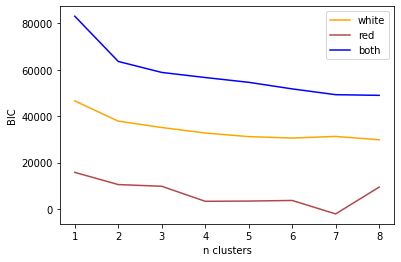

In [275]:
colors = {
    'both': 'b',
    'white': 'orange',
    'red': '#B24849'
}
for bics, label in zip(all_bics, labels):
    plt.plot(np.arange(1,9),bics,label=label, color=colors[label])
plt.xlabel('n clusters')
plt.ylabel('BIC')
plt.legend()
plt.savefig('BIC_plot.png', dpi=200)

Given some prior information that there may be 6 varieties present in the dataset, a likely configuration appears to be 2 white varieties and 4 red varieties.

## Cluster and summarize

In [157]:
WHITE_COMPONENTS = 2
RED_COMPONENTS = 4

white_gm = GaussianMixture(n_components=WHITE_COMPONENTS)
red_gm = GaussianMixture(n_components=RED_COMPONENTS)

white_gm.fit(white)
red_gm.fit(red)

white_cluster_ids = white_gm.predict(white)
red_cluster_ids = red_gm.predict(red)

In [201]:
## Summarize data
all_df = pd.concat([
    white.assign(cluster_id=white_cluster_ids, color='white'),
    red.assign(cluster_id=red_cluster_ids, color='red')])
all_df = (all_df
    .assign(cluster_name=all_df['color']+'_'+(all_df['cluster_id']+1).astype('str'))
    .groupby(['cluster_name','color','cluster_id'])
    .agg(['count','mean'])
    # .agg(['mean',lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)]) # This is too much info for one table
    )

In [203]:
all_df.to_csv('cluster_summary.csv')

## Visualizations

### Radar charts by wine color

In [317]:
def overlapping_radarchart(
    data: pd.DataFrame, 
    cluster_ids: np.ndarray, 
    colors: dict,
    labels: List[str],
    scaler: MinMaxScaler = None,
    ) -> Tuple[plt.Figure, plt.Axes]:
    '''
    Make an overlapped radarchart

    Parameters
    ---------
    data: pd.DataFrame
        Dataframe to be clustered
    cluster_ids: np.ndarray
        Cluster assignments for rows in DataFrame.
    colors: dict
        Dict of cluster_id: color where color is an accepted matplotlib color str.
    labels: List[str]
        list of labels corresponding to clusters
    scaler: MinMaxScaler = None
        Fitted MinMaxScaler instance to scale inputs before plotting. Default=None.

    Returns
    ---------
    fig, axs
    '''
    N = data.shape[1]

    if scaler:
        data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    theta = radar_factory(N, frame='polygon')
    spoke_labels = data.columns

    fig, ax = plt.subplots(figsize=(8, 6), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))

    for cluster_id in range(len(labels)):
        mu = data.loc[cluster_ids==cluster_id,:].values.mean(axis=0)
        ax.plot(theta, mu, color=colors[cluster_id])        

    ax.plot(theta, np.full(len(data.columns),0.6), color='w',alpha=0)

    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    legend = ax.legend(labels, loc=(0.95, .95),
                                labelspacing=0.1, fontsize='small')


    return fig, ax

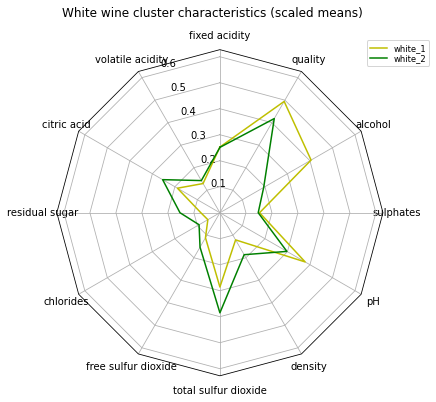

In [318]:
scaler = MinMaxScaler()
scaler.fit(wine)
fig, ax = overlapping_radarchart(
    white, 
    white_cluster_ids, 
    {0: 'y', 1: 'g'}, 
    labels=['white_1','white_2'],
    scaler=scaler)
fig.suptitle('White wine cluster characteristics (scaled means)')
plt.savefig('white_radarchart.png', dpi=200)

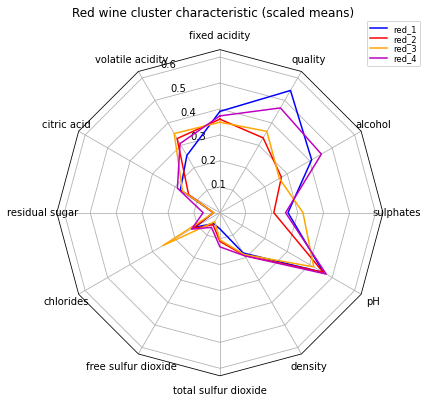

In [319]:
fig, ax = overlapping_radarchart(
    red, 
    red_cluster_ids, 
    {0: 'b', 1: 'r', 2:'orange', 3:'m'}, 
    labels=[f'red_{i}' for i in range(1,5)],
    scaler=scaler
    )
fig.suptitle('Red wine cluster characteristic (scaled means)')
plt.savefig('red_radarchart.png',dpi=200)

### Histogram of probabilities for white wines

In [320]:
probas = white_gm.predict_proba(white)

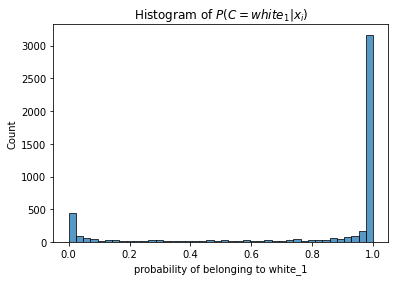

In [321]:
sns.histplot(probas[:,0])
plt.title('Histogram of $P(C=white_1|x_i)$')
plt.xlabel('probability of belonging to white_1')
plt.savefig('histogram_of_p_white_1.png',dpi=150)

In [322]:
## what percent of whites have probabilities 0.25<p<0.75?
np.mean((probas[:,0]>0.25)*(probas[:,0]<0.75))

0.08084932625561454

### Pairplot of selected white wine characteristics

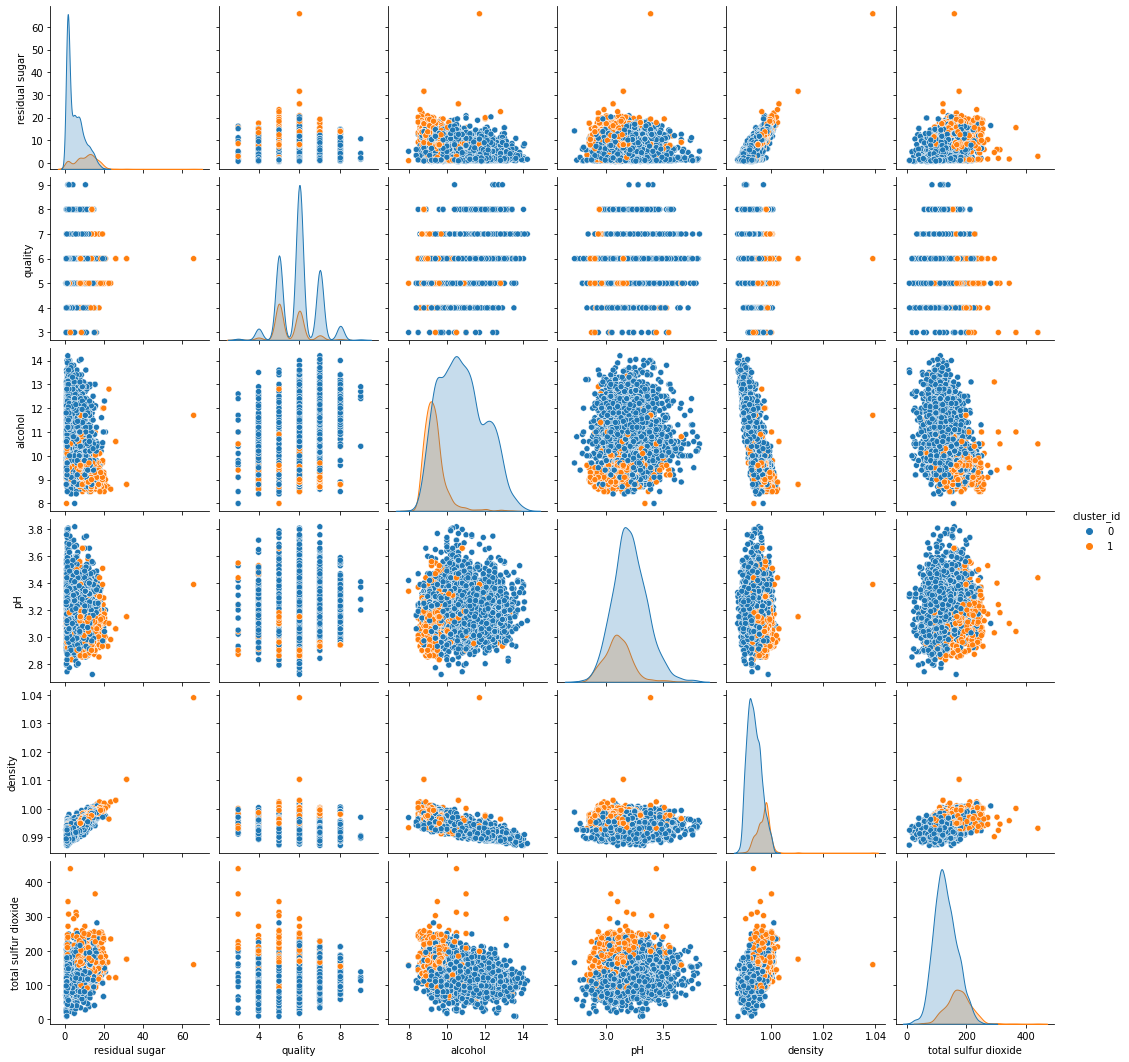

In [323]:
sns.pairplot(
    white.assign(cluster_id=white_cluster_ids)[['cluster_id','residual sugar','quality','alcohol','pH','density','total sulfur dioxide']], 
    hue='cluster_id')